In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size

## Running a Negotiation

NegMAS has several built-in negotiation `Mechanism` s (`Protocol` s), negotiation agents (`Negotiator` s), and `UtilityFunction` s. You can use these to run negotiations as follows:

In [11]:
import random # for generating random ufuns
random.seed(0) # for reproducibility
from pprint import pprint # for printing
from negmas import SAOMechanism, AspirationNegotiator, MappingUtilityFunction

session = SAOMechanism(outcomes=10, n_steps=100)
negotiators = [AspirationNegotiator(name=f'a{_}') for _ in range(5)]
for negotiator in negotiators:
    session.add(negotiator, ufun=MappingUtilityFunction(lambda x: random.random() * x[0]))

pprint(session.run().__dict__)

{'agreement': (4,),
 'broken': False,
 'current_offer': (4,),
 'current_proposer': 'a4-3c56bcb2-0278-45ee-b95b-c696d6a11a54',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 0,
 'n_negotiators': 5,
 'relative_time': 0.96,
 'running': False,
 'started': True,
 'step': 95,
 'time': 0.012729342999989512,
 'timedout': False}


Negotations end with a status that shows you what happens. In the above example, we can see that the negotiation was not broken and did not time-out. The agreement was on outcome `(4,)` of the *10* possible outcomes of this negotiation. That offer was offered by negotiator `a0` (the rest of the agent *ID* is always a random value to ensure no name repetitions) which was accepted by all of the other *4* negotiators.

It is possible to run the same negotiation using a `Protocol` object instead of a `Mechanism` object

In [12]:
random.seed(0) # for reproducibility
from negmas import SAOProtocol

session = SAOProtocol(outcomes=10, n_steps=100)
negotiators = [AspirationNegotiator(name=f'a{_}') for _ in range(5)]
for negotiator in negotiators:
    session.add(negotiator, ufun=MappingUtilityFunction(lambda x: random.random() * x[0]))

pprint(session.run().__dict__)

{'agreement': (4,),
 'broken': False,
 'current_offer': (4,),
 'current_proposer': 'a4-a80ace99-7c18-4f0d-b9b7-9ab32f4b91f9',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 0,
 'n_negotiators': 5,
 'relative_time': 0.96,
 'running': False,
 'started': True,
 'step': 95,
 'time': 0.012701435999986188,
 'timedout': False}


As you can see, we got the same output.`Protocol` is an alias of `Mechanism` in NegMAS.

Let's try a more meaningful situation:
Assume we have a buyer and a seller who are negotiating about a business transaction in which the buyer wants to maximize his profit while the seller wants to minimize her cost. They both would like to transact on as much as possible of the product and each has some preferred delivery time.

This can be modeled in the following negotiation:


In [13]:
from negmas import Issue, SAOMechanism, AspirationNegotiator, normalize
from negmas.utilities import LinearUtilityAggregationFunction as LUFun
issues = [Issue(name='price', values=10), Issue(name='quantity', values=10)
          , Issue(name='delivery_time', values=10)]
session = SAOMechanism(issues=issues, n_steps=5)

buyer_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: 9.0 - x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: x})
                         , outcomes=session.outcomes)

seller_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x})
                           , outcomes=session.outcomes)


session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)
pprint(session.run().__dict__)

{'agreement': {'delivery_time': 8, 'price': 9, 'quantity': 9},
 'broken': False,
 'current_offer': {'delivery_time': 8, 'price': 9, 'quantity': 9},
 'current_proposer': 'seller-bb1ebd4e-b6ea-44ed-a819-2e9d174d0f85',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 0,
 'n_negotiators': 2,
 'relative_time': 1.2,
 'running': False,
 'started': True,
 'step': 5,
 'time': 0.0006966750000287902,
 'timedout': False}


In this run, we can see that the agreement was on a high price (9) which is preferred by the seller but with a delivery time of (8) which is preferred by the buyer. Negotiation took all of the allowed *5* steps.


We can check the negotiation history as well


In [14]:
for i, _ in enumerate(session.history):
    print(f'{i:03}: {_.current_proposer} offered {_.current_offer}')

000: buyer-a7cd6341-d966-42d2-a206-2104750f56c5 offered {'price': 0, 'quantity': 9, 'delivery_time': 9}
001: seller-bb1ebd4e-b6ea-44ed-a819-2e9d174d0f85 offered {'price': 9, 'quantity': 7, 'delivery_time': 0}
002: buyer-a7cd6341-d966-42d2-a206-2104750f56c5 offered {'price': 2, 'quantity': 7, 'delivery_time': 9}
003: seller-bb1ebd4e-b6ea-44ed-a819-2e9d174d0f85 offered {'price': 9, 'quantity': 9, 'delivery_time': 8}
004: seller-bb1ebd4e-b6ea-44ed-a819-2e9d174d0f85 offered {'price': 9, 'quantity': 9, 'delivery_time': 8}


We can even plot the complete negotiation history and visually see how far were the result from the pareto frontier (it was 0.0 utility units far from it). 

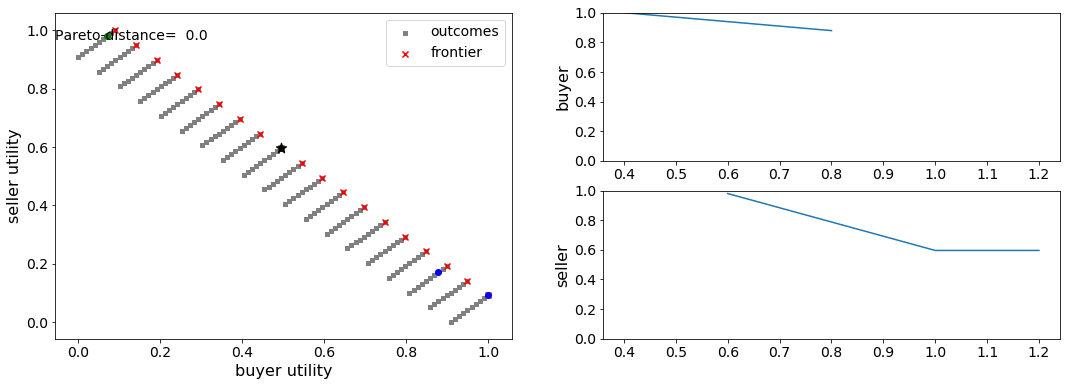

In [15]:
session.plot(plot_outcomes=False)

What happens if the seller was much more interested in delivery time. 

Firstly, what do you expect? 

Given that delivery time becomes a more important issue now, the buyer will get more utility points by allowing the price to go up given that the delivery time can be made earlier. This means that we should expect the delivery time to go down in the agreement and the price to go up if it can. Let's see what happens:

In [16]:
session = SAOMechanism(issues=issues, n_steps=5)

buyer_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x}
                                     , weights = {'price': 1.0, 'quantity': 1.0, 'delivery_time': 10.0})
                         , outcomes=session.outcomes)

session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)
pprint(session.run().__dict__)

{'agreement': {'delivery_time': 0, 'price': 9, 'quantity': 9},
 'broken': False,
 'current_offer': {'delivery_time': 0, 'price': 9, 'quantity': 9},
 'current_proposer': 'buyer-89277840-c43d-4bc3-b7aa-9910efca2130',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 0,
 'n_negotiators': 2,
 'relative_time': 0.6,
 'running': False,
 'started': True,
 'step': 2,
 'time': 0.0003362379999884979,
 'timedout': False}


We can check it visually as well:

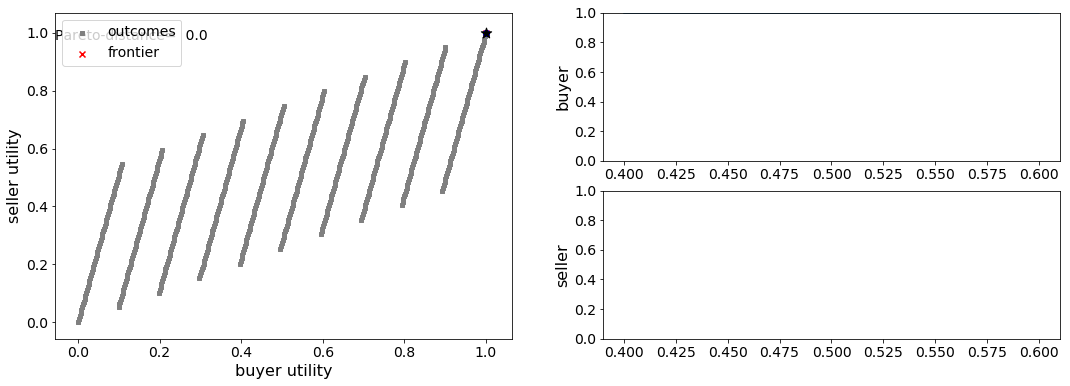

In [17]:
session.plot(plot_outcomes=False)

It is clear that the new ufuns transformed the problem. Now we have a single outcome at the pareto front. The agreement is on it (*0.0* utility points).

What happens if we repeat the earlier neotiation but with a much longer negotiation time:


{'agreement': {'delivery_time': 9, 'price': 9, 'quantity': 9},
 'broken': False,
 'current_offer': {'delivery_time': 9, 'price': 9, 'quantity': 9},
 'current_proposer': 'seller-6f8c4e96-6e66-43aa-9045-431bd587534b',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 0,
 'n_negotiators': 2,
 'relative_time': 0.8225,
 'running': False,
 'started': True,
 'step': 1644,
 'time': 0.2121083879999901,
 'timedout': False}


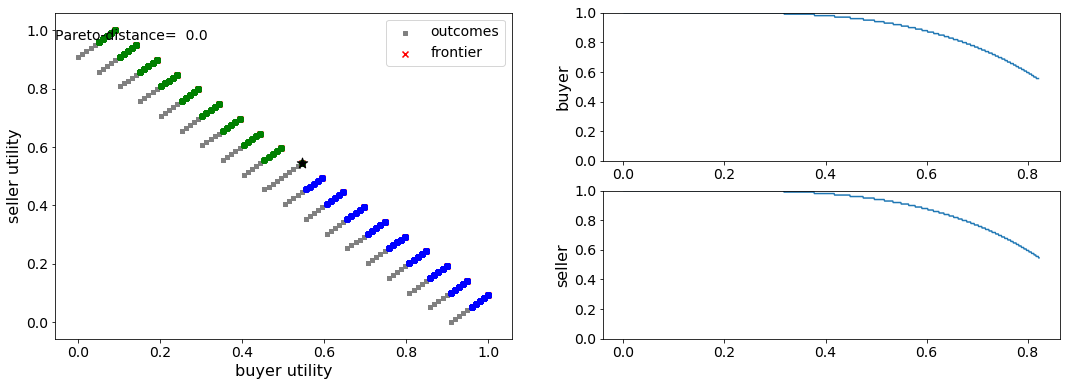

In [18]:
session = SAOMechanism(issues=issues, n_steps=2000)

buyer_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: 9.0 - x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: x})
                         , outcomes=session.outcomes)

seller_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x})
                           , outcomes=session.outcomes)


session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)

pprint(session.run().__dict__)
session.plot(plot_outcomes=False)

Given the longer negotiation time, the buyer and the seller can both take a tougher stance conceding as slowly as possible (taking *1644* steps out of the available *2000* instead of just 5 as before). As a result they again achieve a point exactly on the pareto-front. Moreover, this point happens to maximize the *welfare* defined as the sum of the utility received by both partners.
